# Download Daymet

Daymet provides gridded meteorological data for North American at 1km spatial resolution with daily timestep from 1980 ~ present. [website](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1328) and [user guide](https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html)

Available variables:

| Variable | Description (units) |
| ---- | ---- |
| tmax | Daily maximum 2-meter air temperature (°C) |
| tmin | Daily minimum 2-meter air temperature (°C) |
| prcp | Daily total precipitation (mm/day) |
| srad | Incident shortwave radiation flux density (W/m2) |
| vp   | Water vapor pressure (Pa) |
| swe  | Snow water equivalent (kg/m2) |
| dayl | Duration of the daylight period (seconds/day) |

Notes:
 - The Daymet calendar is based on a standard calendar year. All Daymet years, including leap years, have 1 - 365 days. For leap years, the Daymet database includes leap day (February 29) and values for December 31 are discarded from leap years to maintain a 365-day year.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
import workflow
import workflow.ui
import logging
workflow.ui.setup_logging(1,None)

import numpy as np
import rasterio
import fiona
import workflow.daymet

In [3]:
watershed_shapefile = '../../watershed-workflow/data/hydrologic_units/others/Coweeta/coweeta_basin.shp'

## import watershed

2021-08-25 19:04:04,713 - root - INFO: 
2021-08-25 19:04:04,715 - root - INFO: Loading shapes
2021-08-25 19:04:04,717 - root - INFO: ------------------------------
2021-08-25 19:04:04,719 - root - INFO: Loading file: '../../watershed-workflow/data/hydrologic_units/others/Coweeta/coweeta_basin.shp'
2021-08-25 19:04:04,754 - root - INFO: ... found 1 shapes
2021-08-25 19:04:04,755 - root - INFO: Converting to shapely
2021-08-25 19:04:04,772 - root - INFO: crs: +init=epsg:26917 +type=crs


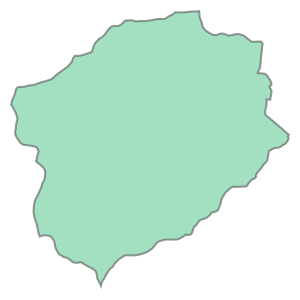

In [4]:
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)
logging.info(f'crs: {crs}')

bounds = watershed.exterior()
bounds

## Download Daymet

returned raw data has `dim(nband, ncol, nrow)`

In [5]:
startdate = "1-2020"
enddate = "365-2020"

In [6]:
# setting vars = None to download all available variables
raw, x, y = workflow.daymet.collectDaymet( bounds, start = startdate, end = enddate, 
                                          crs = crs, vars=None)

2021-08-25 19:04:07,270 - root - INFO: downloading variables: ['tmin', 'tmax', 'prcp', 'srad', 'vp', 'swe', 'dayl']
2021-08-25 19:04:07,377 - root - INFO: Collecting DayMet file to tile bounds: [-83.4885, 35.0173, -83.4117, 35.0838]
2021-08-25 19:04:07,382 - root - INFO:   Using existing: /home/ats_sc_user/short-course/02_model_setup/data/meteorology/daymet/daymet_tmin_2020_35.0838x-83.4885_35.0173x-83.4117.nc
2021-08-25 19:04:07,492 - root - INFO: Collecting DayMet file to tile bounds: [-83.4885, 35.0173, -83.4117, 35.0838]
2021-08-25 19:04:07,494 - root - INFO:   Using existing: /home/ats_sc_user/short-course/02_model_setup/data/meteorology/daymet/daymet_tmax_2020_35.0838x-83.4885_35.0173x-83.4117.nc
2021-08-25 19:04:07,588 - root - INFO: Collecting DayMet file to tile bounds: [-83.4885, 35.0173, -83.4117, 35.0838]
2021-08-25 19:04:07,590 - root - INFO:   Using existing: /home/ats_sc_user/short-course/02_model_setup/data/meteorology/daymet/daymet_prcp_2020_35.0838x-83.4885_35.0173x-8

## Reproject Daymet CRS (optional)

Reproject daymet CRS to the same as the watershed. This is necessary if watershed meshes are using watershed CRS that is different from Daymet CRS.

In [8]:
new_x, new_y, new_extent, new_dat, daymet_profile = workflow.daymet.reproj_Daymet(x, y, raw,  dst_crs = crs)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:1216: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
2021-08-25 04:54:04,214 - root - INFO: daymet profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 9, 'height': 9, 'count': 365, 'crs': <Projected CRS: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=- ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, 'transform': Affine(1000.0, 0.0, 1440250.0,
       0.0, -1000.0, -643500.0), 'tiled': False, 'interleave': 'pixel'}
2021-08-25 04:54:04,215 - root - INFO:

AttributeError: 'CRS' object has no attribute 'wkt'

## plot Daymet

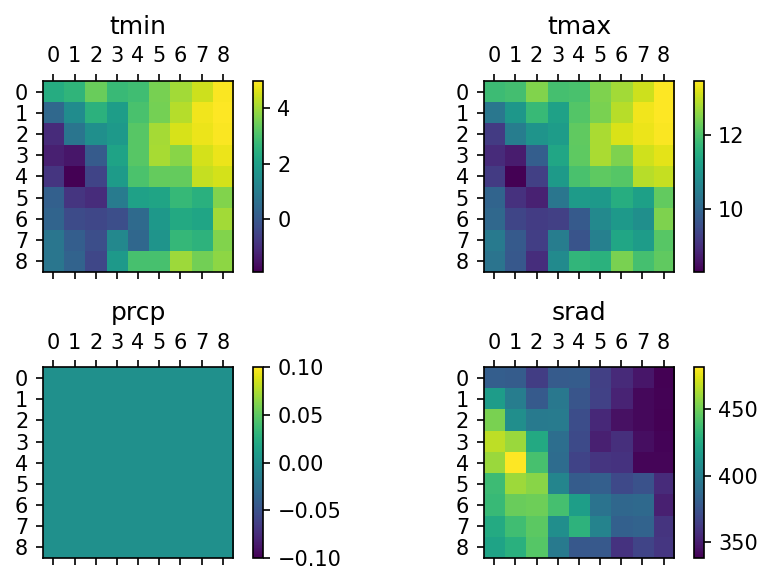

In [7]:
variables = ['tmin', 'tmax', 'prcp', 'srad']
islice = 100
fig, axes = plt.subplots(2, 2)

for ivar,ax in zip(variables, axes.flatten()):
    iraster = raw[ivar][islice, :, :]
    im = ax.matshow(iraster)
    ax.set_title(ivar)
    plt.colorbar(im, ax = ax)
    
fig.tight_layout()

In [ ]:
ivar = 'tmax'
islice = 100
fig, axes = plt.subplots(1, 2)

ax = axes[0]
extent = rasterio.transform.array_bounds(daymet_profile['height'], daymet_profile['width'], daymet_profile['transform']) # (x0, y0, x1, y1)
plot_extent = extent[0], extent[2], extent[1], extent[3]

iraster = raw[ivar][islice, :, :]

with fiona.open(watershed_shapefile, mode='r') as fid:
    bnd_profile = fid.profile
    bnd = [r for (i,r) in fid.items()]
daymet_crs = workflow.crs.daymet_crs()

# convert to destination crs
native_crs = workflow.crs.from_fiona(bnd_profile['crs'])
reproj_bnd = workflow.warp.shape(bnd[0], native_crs, daymet_crs)
reproj_bnd_shply = workflow.utils.shply(reproj_bnd)

cax = ax.matshow(iraster, extent=plot_extent, alpha=1)
ax.plot(*reproj_bnd_shply.exterior.xy, 'r')
ax.set_title("Raw Daymet")


ax = axes[1]
extent = new_extent # (x0, y0, x1, y1)
plot_extent = extent[0], extent[2], extent[1], extent[3] # (x0, x1, y0, y1)

iraster = new_dat[ivar][islice, :, :]

# set nodata to NaN to avoid plotting
iraster[iraster == -9999] = np.nan

workflow.plot.hucs(watershed, crs, ax=ax, color='r', linewidth=1)
im = ax.matshow(iraster, extent=plot_extent)
ax.set_title("Reprojected Daymet")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax)

# save daymet

In [ ]:
workflow.daymet.writeHDF5(raw, x, y, 
                         workflow.daymet.getAttrs(bounds.bounds, startdate, enddate), 
                         'coweeta_daymet-raw.h5')

## Write to ATS format

This will write daymet in a format that ATS can read. E.g., this will partition precipitation into rain and snow, convert vapor pressure to relative humidity, get mean air temperature and so on.

- dout has dims of `(ntime, nrow, ncol)` or `(ntime, ny, nx)`

In [ ]:
workflow.daymet.writeATS(raw, x, y, 
                         workflow.daymet.getAttrs(bounds.bounds, startdate, enddate), 
                         'coweeta_daymet-ats.h5')